In [13]:
import torch
import pandas as pd
from scipy.spatial.distance import cosine, pdist, squareform
from torch.nn.functional import cosine_similarity
import seaborn
import matplotlib.pyplot as plt
from transformers import WhisperTokenizer

In [3]:
ft_embed_path='../../data/langtok_experiment/ft_embed_tokens.pt'
med_embed_path='../../data/langtok_experiment/med_embed_tokens.pt'

In [8]:
ft_embeds=torch.load(ft_embed_path).weight.detach()
med_embeds=torch.load(med_embed_path).weight.detach()
ft_embeds.shape, med_embeds.shape

(torch.Size([51865, 1024]), torch.Size([51865, 1024]))

In [5]:
tok=WhisperTokenizer.from_pretrained('openai/whisper-medium')
nonlang_additional_special_tokens=[
    '<|endoftext|>',
    '<|startoftranscript|>',
    '<|translate|>',
    '<|transcribe|>',
    '<|startoflm|>',
    '<|startofprev|>',
    '<|nocaptions|>',
    '<|notimestamps|>',
]
lang_tokens = [
    tok for tok in tok.special_tokens_map['additional_special_tokens']
    if tok not in nonlang_additional_special_tokens
]
lang_ids = tok.convert_tokens_to_ids(lang_tokens)
lang_ids


[50259,
 50260,
 50261,
 50262,
 50263,
 50264,
 50265,
 50266,
 50267,
 50268,
 50269,
 50270,
 50271,
 50272,
 50273,
 50274,
 50275,
 50276,
 50277,
 50278,
 50279,
 50280,
 50281,
 50282,
 50283,
 50284,
 50285,
 50286,
 50287,
 50288,
 50289,
 50290,
 50291,
 50292,
 50293,
 50294,
 50295,
 50296,
 50297,
 50298,
 50299,
 50300,
 50301,
 50302,
 50303,
 50304,
 50305,
 50306,
 50307,
 50308,
 50309,
 50310,
 50311,
 50312,
 50313,
 50314,
 50315,
 50316,
 50317,
 50318,
 50319,
 50320,
 50321,
 50322,
 50323,
 50324,
 50325,
 50326,
 50327,
 50328,
 50329,
 50330,
 50331,
 50332,
 50333,
 50334,
 50335,
 50336,
 50337,
 50338,
 50339,
 50340,
 50341,
 50342,
 50343,
 50344,
 50345,
 50346,
 50347,
 50348,
 50349,
 50350,
 50351,
 50352,
 50353,
 50354,
 50355,
 50356,
 50357]

In [25]:
sw_tok_id = tok.encode('<|sw|>', add_special_tokens=False)[0]
sw_tok_id

50318

### Visualize similarity between language token embeddings

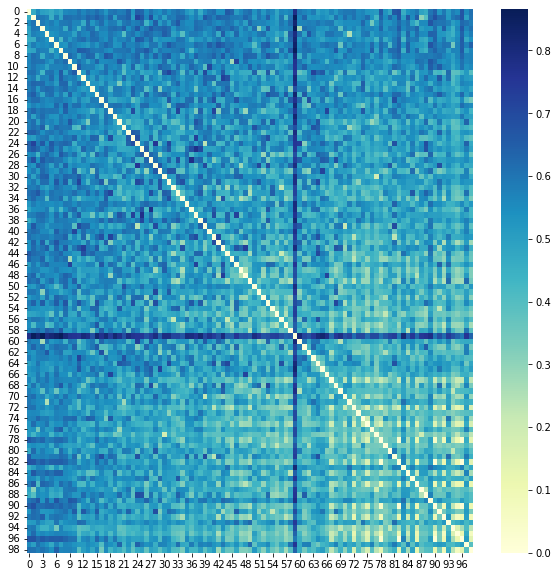

In [9]:
def dist_matrix(embeds_tensor):
    dist_mat=squareform(pdist(embeds_tensor,cosine))
    dist_mat.shape
    dist_df=pd.DataFrame(dist_mat)
    fig, ax = plt.subplots(figsize=(10,10))
    seaborn.heatmap(dist_df, cmap='YlGnBu')
dist_matrix(ft_embeds[lang_ids])

### Compare average cosine distance from mean embedding for lang token embeddings and all other embeddings

In [12]:
avg_embed = med_embeds.mean(dim=0)
avg_lang_id = med_embeds[lang_ids].mean(dim=0)
avg_embed.shape, avg_lang_id.shape

(torch.Size([1024]), torch.Size([1024]))

In [29]:
tira_embed = ft_embeds[sw_tok_id]
sw_embed = med_embeds[sw_tok_id]
cosine_similarity(tira_embed, sw_embed, dim=0)

tensor(0.2236)

In [16]:
embed_cos_sim=cosine_similarity(med_embeds, avg_embed)
embed_cos_sim

tensor([-0.2125,  0.2985,  0.8054,  ...,  0.8595,  0.8863,  0.9245])

In [ ]:
langid_cos_sim=cosine_similarity(med_embeds[lang_ids], avg_embed)
langid_cos_sim

(tensor([0.3661, 0.3576, 0.4051, 0.3849, 0.4054, 0.3883, 0.3908, 0.3808, 0.3977,
         0.4104, 0.4244, 0.5587, 0.4689, 0.4549, 0.5102, 0.4013, 0.4626, 0.4440,
         0.5120, 0.4251, 0.5445, 0.5561, 0.4947, 0.5342, 0.5198, 0.5109, 0.5950,
         0.4913, 0.4919, 0.5917, 0.4651, 0.4970, 0.6172, 0.6148, 0.6439, 0.4674,
         0.5619, 0.5064, 0.4810, 0.6134, 0.5236, 0.5576, 0.6522, 0.5217, 0.6800,
         0.6613, 0.5649, 0.6804, 0.6693, 0.7457, 0.5527, 0.6219, 0.6554, 0.6101,
         0.6212, 0.6680, 0.6516, 0.7241, 0.6757, 0.5802, 0.5820, 0.6426, 0.6387,
         0.5734, 0.4828, 0.5442, 0.5825, 0.8053, 0.6439, 0.6173, 0.7394, 0.5928,
         0.8390, 0.6594, 0.7230, 0.8483, 0.6237, 0.7013, 0.9418, 0.6854, 0.6454,
         0.6317, 0.9628, 0.4665, 0.7257, 0.5526, 0.8610, 0.6373, 0.6346, 0.5072,
         0.9568, 0.6581, 0.8656, 0.5336, 0.7719, 0.8827, 0.9630, 0.5234, 0.8431]),
 tensor(0.3576))

In [37]:
langid_langid_cos_sim=cosine_similarity(med_embeds[lang_ids], avg_lang_id)
langid_langid_cos_sim

tensor([0.6222, 0.5995, 0.6181, 0.6171, 0.6329, 0.6450, 0.6141, 0.6136, 0.6063,
        0.6359, 0.6303, 0.6743, 0.6534, 0.6743, 0.6688, 0.6294, 0.6683, 0.6459,
        0.6756, 0.6639, 0.7036, 0.6891, 0.6792, 0.6808, 0.6584, 0.6577, 0.7018,
        0.6650, 0.6636, 0.7126, 0.6719, 0.6673, 0.7265, 0.6904, 0.7475, 0.6617,
        0.7043, 0.6852, 0.6601, 0.7172, 0.6708, 0.6963, 0.7385, 0.6716, 0.7197,
        0.7651, 0.6887, 0.7675, 0.7440, 0.7650, 0.6947, 0.7378, 0.7614, 0.7186,
        0.7553, 0.8051, 0.7402, 0.7994, 0.7522, 0.7173, 0.7108, 0.7290, 0.7445,
        0.7006, 0.6800, 0.6988, 0.7221, 0.8212, 0.7360, 0.7546, 0.7864, 0.7279,
        0.8502, 0.7788, 0.7590, 0.8441, 0.7569, 0.8434, 0.8153, 0.7987, 0.7555,
        0.7225, 0.7953, 0.6909, 0.7912, 0.7142, 0.8173, 0.7727, 0.7503, 0.6785,
        0.8091, 0.7430, 0.8325, 0.7041, 0.8454, 0.8628, 0.7893, 0.7017, 0.8288])

In [39]:
embed_cos_sim.min(), embed_cos_sim.mean(), embed_cos_sim.std()

(tensor(-0.4337), tensor(0.8909), tensor(0.0640))

In [38]:
langid_langid_cos_sim.min(), langid_langid_cos_sim.mean(), langid_langid_cos_sim.std()

(tensor(0.5995), tensor(0.7182), tensor(0.0638))

In [31]:
langid_cos_sim.min(), langid_cos_sim.mean(), langid_cos_sim.std()

(tensor(0.3576), tensor(0.5965), tensor(0.1427))